In [1]:
from selenium import webdriver
from time import sleep
from scrapy.selector import Selector
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
from selenium.webdriver.common.keys import Keys
from math import sin, cos, sqrt,atan2, radians
from selenium.webdriver.chrome.options import Options
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

chromedriver = "/home/btan/Documents/chromedriver"

chrome_options = Options()
chrome_options.add_argument("--headless")

print('Update: Library import completed!')

Update: Library import completed!


In [2]:
# load necessary files

houses = pd.read_csv('./datasets/output/2018/resale-price-output-0.csv', index_col = 'Unnamed: 0')
trains = pd.read_csv('./datasets/sg-train-station-updated-2019-05-16.csv', index_col = 'Unnamed: 0')
schools = pd.read_csv('./datasets/schools-updated-2019-05-16.csv', index_col = 'Unnamed: 0')

print('Update: csv files successfully loaded')

Update: csv files successfully loaded


In [3]:
# function to get distance between 2 points

def get_dist (lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(float(lat1))
    lon1 = radians(float(lon1))
    lat2 = radians(float(lat2))
    lon2 = radians(float(lon2))
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return round(distance,4)

In [4]:
# populate the house dataset with more 2018 data

for data in range(1,261):
    temp1 = pd.read_csv('./datasets/output/2018/resale-price-output-{}.csv'.format(data), index_col = 'Unnamed: 0')
    houses = pd.concat( [houses, temp1], sort=True)  
    
print('Update: Successfully loaded 2018 data')    

# populate the house dataset with 2013 data

for data in range(0,161):
    temp1 = pd.read_csv('./datasets/output/2013/resale-price-output-{}.csv'.format(data), index_col = 'Unnamed: 0')
    houses = pd.concat( [houses, temp1], sort=True)
    
print('Update: Successfully loaded 2013 data')        
    
# populate the house dataset with 2014 data

for data in range(0,161):
    temp1 = pd.read_csv('./datasets/output/2014/resale-price-output-{}.csv'.format(data), index_col = 'Unnamed: 0')
    houses = pd.concat( [houses, temp1], sort=True)
    
print('Update: Successfully loaded 2014 data')        
    
# populate the house dataset with 2015 data

for data in range(0,178):
    temp1 = pd.read_csv('./datasets/output/2015/resale-price-output-{}.csv'.format(data), index_col = 'Unnamed: 0')
    houses = pd.concat( [houses, temp1], sort=True)    
    
print('Update: Successfully loaded 2015 data')        
    
# populate the house dataset with 2016 data

for data in range(0,194):
    temp1 = pd.read_csv('./datasets/output/2016/resale-price-output-{}.csv'.format(data), index_col = 'Unnamed: 0')
    houses = pd.concat( [houses, temp1], sort=True)    
    
print('Update: Successfully loaded 2016 data')
    

# populate the house dataset with 2017 data

for data in range(0,204):
    temp1 = pd.read_csv('./datasets/output/2017/resale-price-output-{}.csv'.format(data), index_col = 'Unnamed: 0')
    houses = pd.concat( [houses, temp1], sort=True)     
    
print('Update: Successfully loaded 2017 data')        

houses.reset_index(drop = True, inplace = True)

print('Update: File loading complete! Data contains {} entries'.format(len(houses)))

Update: Successfully loaded 2018 data
Update: Successfully loaded 2013 data
Update: Successfully loaded 2014 data
Update: Successfully loaded 2015 data
Update: Successfully loaded 2016 data
Update: Successfully loaded 2017 data
Update: File loading complete! Data contains 115791 entries


In [5]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115791 entries, 0 to 115790
Data columns (total 23 columns):
block                  115791 non-null object
busstop1_dist          115791 non-null int64
busstop1_name          115791 non-null object
busstop2_dist          115791 non-null int64
busstop2_name          115791 non-null object
busstop3_dist          115791 non-null int64
busstop3_name          115791 non-null object
flat_model             115791 non-null object
flat_type              115791 non-null object
floor_area_sqm         115791 non-null int64
lease_commence_date    115791 non-null int64
loc_lat                115791 non-null float64
loc_lon                115791 non-null float64
month                  115791 non-null object
nearest_mrt_dist       115791 non-null float64
nearest_mrt_name       115791 non-null object
remaining_lease        115791 non-null int64
resale_price           115791 non-null int64
storey_range           115791 non-null object
street_name        

In [6]:
# set correct data type
houses.nearest_mrt_dist = houses.nearest_mrt_dist.astype(float)
houses.busstop1_dist = houses.busstop1_dist.astype(float)
houses.busstop2_dist = houses.busstop2_dist.astype(float)
houses.busstop3_dist = houses.busstop3_dist.astype(float)

# create column for train/bus stop codes
houses['nearest_mrt_code'] = houses['nearest_mrt_name'].map(lambda x: x[ int(x.find('[')+1) : x.find(']')].split('/')[0])
houses['busstop1_code'] = houses['busstop1_name'].map(lambda x: x[ int(x.find(':')+1) : x.find('-')])
houses['busstop2_code'] = houses['busstop2_name'].map(lambda x: x[ int(x.find(':')+1) : x.find('-')])
houses['busstop3_code'] = houses['busstop3_name'].map(lambda x: x[ int(x.find(':')+1) : x.find('-')])

print('Update: Successfully extracted codes for MRT, Bus Stop 1, Bus Stop 2, Bus Stop 3')

Update: Successfully extracted codes for MRT, Bus Stop 1, Bus Stop 2, Bus Stop 3


In [7]:
# create columns for the nearest schools details: name, address, postal, lat, lon, dist

houses['nearest_sch_primary_name'] = ''
houses['nearest_sch_primary_address'] = ''
houses['nearest_sch_primary_postalcode'] = 0
houses['nearest_sch_primary_lat'] = 0.0
houses['nearest_sch_primary_lon'] = 0.0
houses['nearest_sch_primary_dist'] = 0.0

houses['nearest_sch_secondary_name'] = ''
houses['nearest_sch_secondary_address'] = ''
houses['nearest_sch_secondary_postalcode'] = 0
houses['nearest_sch_secondary_lat'] = 0.0
houses['nearest_sch_secondary_lon'] = 0.0
houses['nearest_sch_secondary_dist'] = 0.0

houses['nearest_sch_juniorcollege_name'] = ''
houses['nearest_sch_juniorcollege_address'] = ''
houses['nearest_sch_juniorcollege_postalcode'] = 0
houses['nearest_sch_juniorcollege_lat'] = 0.0
houses['nearest_sch_juniorcollege_lon'] = 0.0
houses['nearest_sch_juniorcollege_dist'] = 0.0

houses['nearest_sch_polytechnic_name'] = ''
houses['nearest_sch_polytechnic_address'] = ''
houses['nearest_sch_polytechnic_postalcode'] = 0
houses['nearest_sch_polytechnic_lat'] = 0.0
houses['nearest_sch_polytechnic_lon'] = 0.0
houses['nearest_sch_polytechnic_dist'] = 0.0

houses['nearest_sch_university_name'] = ''
houses['nearest_sch_university_address'] = ''
houses['nearest_sch_university_postalcode'] = 0
houses['nearest_sch_university_lat'] = 0.0
houses['nearest_sch_university_lon'] = 0.0
houses['nearest_sch_university_dist'] = 0.0

In [8]:
# function used to find the nearest school from the house

def find_nearest_school(base_index):
    
    nearest_pri_index = 0
    nearest_pri_dist = 999999.9
    
    for school in schools[schools.type_primary == 1].index :
        dist = get_dist(houses.loc[base_index, 'loc_lat'], houses.loc[base_index, 'loc_lon'], 
                        schools.loc[school, 'sch_lat'], schools.loc[school, 'sch_lon'])
        if dist < nearest_pri_dist:
            nearest_pri_dist = dist
            nearest_pri_index = school    
            
    nearest_sec_index = 0
    nearest_sec_dist = 999999.9
    
    for school in schools[schools.type_secondary == 1].index :
        dist = get_dist(houses.loc[base_index, 'loc_lat'], houses.loc[base_index, 'loc_lon'], 
                        schools.loc[school, 'sch_lat'], schools.loc[school, 'sch_lon'])
        if dist < nearest_sec_dist:
            nearest_sec_dist = dist
            nearest_sec_index = school                
            
    nearest_jc_index = 0
    nearest_jc_dist = 999999.9
    
    for school in schools[schools.type_juniorcollege == 1].index :
        dist = get_dist(houses.loc[base_index, 'loc_lat'], houses.loc[base_index, 'loc_lon'], 
                        schools.loc[school, 'sch_lat'], schools.loc[school, 'sch_lon'])
        if dist < nearest_jc_dist:
            nearest_jc_dist = dist
            nearest_jc_index = school    
    
    nearest_poly_index = 0
    nearest_poly_dist = 999999.9
    
    for school in schools[schools.type_polytechnic == 1].index :
        dist = get_dist(houses.loc[base_index, 'loc_lat'], houses.loc[base_index, 'loc_lon'], 
                        schools.loc[school, 'sch_lat'], schools.loc[school, 'sch_lon'])
        if dist < nearest_poly_dist:
            nearest_poly_dist = dist
            nearest_poly_index = school    
            
    nearest_uni_index = 0
    nearest_uni_dist = 999999.9
    
    for school in schools[schools.type_university == 1].index :
        dist = get_dist(houses.loc[base_index, 'loc_lat'], houses.loc[base_index, 'loc_lon'], 
                        schools.loc[school, 'sch_lat'], schools.loc[school, 'sch_lon'])
        if dist < nearest_uni_dist:
            nearest_uni_dist = dist
            nearest_uni_index = school    
            
    houses.loc[base_index, 'nearest_sch_primary_name'] = schools.loc[nearest_pri_index, 'school_name']
    houses.loc[base_index, 'nearest_sch_primary_address'] = schools.loc[nearest_pri_index, 'address']
    houses.loc[base_index, 'nearest_sch_primary_postalcode'] = schools.loc[nearest_pri_index, 'postal_code']
    houses.loc[base_index, 'nearest_sch_primary_lat'] = schools.loc[nearest_pri_index, 'sch_lat']
    houses.loc[base_index, 'nearest_sch_primary_lon'] = schools.loc[nearest_pri_index, 'sch_lon']
    houses.loc[base_index, 'nearest_sch_primary_dist'] = nearest_pri_dist
 
    houses.loc[base_index, 'nearest_sch_secondary_name'] = schools.loc[nearest_sec_index, 'school_name']
    houses.loc[base_index, 'nearest_sch_secondary_address'] = schools.loc[nearest_sec_index, 'address']
    houses.loc[base_index, 'nearest_sch_secondary_postalcode'] = schools.loc[nearest_sec_index, 'postal_code']
    houses.loc[base_index, 'nearest_sch_secondary_lat'] = schools.loc[nearest_sec_index, 'sch_lat']
    houses.loc[base_index, 'nearest_sch_secondary_lon'] = schools.loc[nearest_sec_index, 'sch_lon']
    houses.loc[base_index, 'nearest_sch_secondary_dist'] = nearest_sec_dist

    houses.loc[base_index, 'nearest_sch_juniorcollege_name'] = schools.loc[nearest_jc_index, 'school_name']
    houses.loc[base_index, 'nearest_sch_juniorcollege_address'] = schools.loc[nearest_jc_index, 'address']
    houses.loc[base_index, 'nearest_sch_juniorcollege_postalcode'] = schools.loc[nearest_jc_index, 'postal_code']
    houses.loc[base_index, 'nearest_sch_juniorcollege_lat'] = schools.loc[nearest_jc_index, 'sch_lat']
    houses.loc[base_index, 'nearest_sch_juniorcollege_lon'] = schools.loc[nearest_jc_index, 'sch_lon']
    houses.loc[base_index, 'nearest_sch_juniorcollege_dist'] = nearest_jc_dist

    houses.loc[base_index, 'nearest_sch_polytechnic_name'] = schools.loc[nearest_poly_index, 'school_name']
    houses.loc[base_index, 'nearest_sch_polytechnic_address'] = schools.loc[nearest_poly_index, 'address']
    houses.loc[base_index, 'nearest_sch_polytechnic_postalcode'] = schools.loc[nearest_poly_index, 'postal_code']
    houses.loc[base_index, 'nearest_sch_polytechnic_lat'] = schools.loc[nearest_poly_index, 'sch_lat']
    houses.loc[base_index, 'nearest_sch_polytechnic_lon'] = schools.loc[nearest_poly_index, 'sch_lon']
    houses.loc[base_index, 'nearest_sch_polytechnic_dist'] = nearest_poly_dist

    houses.loc[base_index, 'nearest_sch_university_name'] = schools.loc[nearest_uni_index, 'school_name']
    houses.loc[base_index, 'nearest_sch_university_address'] = schools.loc[nearest_uni_index, 'address']
    houses.loc[base_index, 'nearest_sch_university_postalcode'] = schools.loc[nearest_uni_index, 'postal_code']
    houses.loc[base_index, 'nearest_sch_university_lat'] = schools.loc[nearest_uni_index, 'sch_lat']
    houses.loc[base_index, 'nearest_sch_university_lon'] = schools.loc[nearest_uni_index, 'sch_lon']
    houses.loc[base_index, 'nearest_sch_university_dist'] = nearest_uni_dist

In [9]:
houses.to_csv('./datasets/resale-1318-raw.csv')

In [10]:
#####################################
# start of execution code
#####################################

In [11]:
# combined details from the MRT dataset into houses

houses['nearest_mrt_line'] = ''
houses['nearest_mrt_lat'] = 0.0
houses['nearest_mrt_lon'] = 0.0
houses['nearest_mrt_dist_centre'] = 0.0

houses['nearest_mrt_line'] = houses['nearest_mrt_code'].map(lambda x: trains[trains.stn_code==x]['mrt_line_english'].unique()[0])
houses['nearest_mrt_lat'] = houses['nearest_mrt_code'].map(lambda x: trains[trains.stn_code==x]['stn_lat'].unique()[0])
houses['nearest_mrt_lon'] = houses['nearest_mrt_code'].map(lambda x: trains[trains.stn_code==x]['stn_lon'].unique()[0])
houses['nearest_mrt_dist_centre'] = houses['nearest_mrt_code'].map(lambda x: trains[trains.stn_code==x]['dist_centre'].unique()[0])

print('Update: Successfully extracted nearest MRT details')

Update: Successfully extracted nearest MRT details


In [12]:
houses = houses[['month', 'town', 'flat_type', 'block', 'street_name',
                    'storey_range', 'floor_area_sqm', 'flat_model',
                    'lease_commence_date', 'remaining_lease', 'resale_price',
                    'transaction_year', 'transaction_month', 'loc_lat', 'loc_lon',

                    'nearest_mrt_name', 'nearest_mrt_dist', 'nearest_mrt_code',  'nearest_mrt_line',
                    'nearest_mrt_lat', 'nearest_mrt_lon', 'nearest_mrt_dist_centre',

                    'busstop1_name', 'busstop1_code', 'busstop1_dist', 
                    'busstop2_name', 'busstop2_code', 'busstop2_dist', 
                    'busstop3_name', 'busstop3_code', 'busstop3_dist',

                    'nearest_sch_primary_name', 'nearest_sch_primary_address',
                    'nearest_sch_primary_postalcode', 'nearest_sch_primary_lat',
                    'nearest_sch_primary_lon', 'nearest_sch_primary_dist',

                    'nearest_sch_secondary_name', 'nearest_sch_secondary_address',
                    'nearest_sch_secondary_postalcode', 'nearest_sch_secondary_lat',
                    'nearest_sch_secondary_lon', 'nearest_sch_secondary_dist',

                    'nearest_sch_juniorcollege_name', 'nearest_sch_juniorcollege_address',
                    'nearest_sch_juniorcollege_postalcode', 'nearest_sch_juniorcollege_lat', 
                    'nearest_sch_juniorcollege_lon', 'nearest_sch_juniorcollege_dist', 

                    'nearest_sch_polytechnic_name', 'nearest_sch_polytechnic_address',
                    'nearest_sch_polytechnic_postalcode', 'nearest_sch_polytechnic_lat', 
                    'nearest_sch_polytechnic_lon', 'nearest_sch_polytechnic_dist', 

                    'nearest_sch_university_name', 'nearest_sch_university_address',
                    'nearest_sch_university_postalcode', 'nearest_sch_university_lat',
                    'nearest_sch_university_lon', 'nearest_sch_university_dist',
                       
                ]]

In [13]:
houses.to_csv('./datasets/resale-1318-raw1.csv')

In [14]:
# find the nearest schools from the house

houses.reset_index(drop=True, inplace=True)

for house in range(len(houses)):
    find_nearest_school(house)
    if house % 100 == 0:
        print('completed {} of {} entries'.format(house, len(houses)))

completed 0 of 115791 entries
completed 100 of 115791 entries
completed 200 of 115791 entries
completed 300 of 115791 entries
completed 400 of 115791 entries
completed 500 of 115791 entries
completed 600 of 115791 entries
completed 700 of 115791 entries
completed 800 of 115791 entries
completed 900 of 115791 entries
completed 1000 of 115791 entries
completed 1100 of 115791 entries
completed 1200 of 115791 entries
completed 1300 of 115791 entries
completed 1400 of 115791 entries
completed 1500 of 115791 entries
completed 1600 of 115791 entries
completed 1700 of 115791 entries
completed 1800 of 115791 entries
completed 1900 of 115791 entries
completed 2000 of 115791 entries
completed 2100 of 115791 entries
completed 2200 of 115791 entries
completed 2300 of 115791 entries
completed 2400 of 115791 entries
completed 2500 of 115791 entries
completed 2600 of 115791 entries
completed 2700 of 115791 entries
completed 2800 of 115791 entries
completed 2900 of 115791 entries
completed 3000 of 1157

completed 24500 of 115791 entries
completed 24600 of 115791 entries
completed 24700 of 115791 entries
completed 24800 of 115791 entries
completed 24900 of 115791 entries
completed 25000 of 115791 entries
completed 25100 of 115791 entries
completed 25200 of 115791 entries
completed 25300 of 115791 entries
completed 25400 of 115791 entries
completed 25500 of 115791 entries
completed 25600 of 115791 entries
completed 25700 of 115791 entries
completed 25800 of 115791 entries
completed 25900 of 115791 entries
completed 26000 of 115791 entries
completed 26100 of 115791 entries
completed 26200 of 115791 entries
completed 26300 of 115791 entries
completed 26400 of 115791 entries
completed 26500 of 115791 entries
completed 26600 of 115791 entries
completed 26700 of 115791 entries
completed 26800 of 115791 entries
completed 26900 of 115791 entries
completed 27000 of 115791 entries
completed 27100 of 115791 entries
completed 27200 of 115791 entries
completed 27300 of 115791 entries
completed 2740

completed 48600 of 115791 entries
completed 48700 of 115791 entries
completed 48800 of 115791 entries
completed 48900 of 115791 entries
completed 49000 of 115791 entries
completed 49100 of 115791 entries
completed 49200 of 115791 entries
completed 49300 of 115791 entries
completed 49400 of 115791 entries
completed 49500 of 115791 entries
completed 49600 of 115791 entries
completed 49700 of 115791 entries
completed 49800 of 115791 entries
completed 49900 of 115791 entries
completed 50000 of 115791 entries
completed 50100 of 115791 entries
completed 50200 of 115791 entries
completed 50300 of 115791 entries
completed 50400 of 115791 entries
completed 50500 of 115791 entries
completed 50600 of 115791 entries
completed 50700 of 115791 entries
completed 50800 of 115791 entries
completed 50900 of 115791 entries
completed 51000 of 115791 entries
completed 51100 of 115791 entries
completed 51200 of 115791 entries
completed 51300 of 115791 entries
completed 51400 of 115791 entries
completed 5150

completed 72700 of 115791 entries
completed 72800 of 115791 entries
completed 72900 of 115791 entries
completed 73000 of 115791 entries
completed 73100 of 115791 entries
completed 73200 of 115791 entries
completed 73300 of 115791 entries
completed 73400 of 115791 entries
completed 73500 of 115791 entries
completed 73600 of 115791 entries
completed 73700 of 115791 entries
completed 73800 of 115791 entries
completed 73900 of 115791 entries
completed 74000 of 115791 entries
completed 74100 of 115791 entries
completed 74200 of 115791 entries
completed 74300 of 115791 entries
completed 74400 of 115791 entries
completed 74500 of 115791 entries
completed 74600 of 115791 entries
completed 74700 of 115791 entries
completed 74800 of 115791 entries
completed 74900 of 115791 entries
completed 75000 of 115791 entries
completed 75100 of 115791 entries
completed 75200 of 115791 entries
completed 75300 of 115791 entries
completed 75400 of 115791 entries
completed 75500 of 115791 entries
completed 7560

completed 96800 of 115791 entries
completed 96900 of 115791 entries
completed 97000 of 115791 entries
completed 97100 of 115791 entries
completed 97200 of 115791 entries
completed 97300 of 115791 entries
completed 97400 of 115791 entries
completed 97500 of 115791 entries
completed 97600 of 115791 entries
completed 97700 of 115791 entries
completed 97800 of 115791 entries
completed 97900 of 115791 entries
completed 98000 of 115791 entries
completed 98100 of 115791 entries
completed 98200 of 115791 entries
completed 98300 of 115791 entries
completed 98400 of 115791 entries
completed 98500 of 115791 entries
completed 98600 of 115791 entries
completed 98700 of 115791 entries
completed 98800 of 115791 entries
completed 98900 of 115791 entries
completed 99000 of 115791 entries
completed 99100 of 115791 entries
completed 99200 of 115791 entries
completed 99300 of 115791 entries
completed 99400 of 115791 entries
completed 99500 of 115791 entries
completed 99600 of 115791 entries
completed 9970

In [15]:
# get the create dummy columns for the floor range

houses['floor_0103'] = houses.storey_range.map(lambda x: 1 if '01 TO 03' in x else 0)
houses['floor_0406'] = houses.storey_range.map(lambda x: 1 if '04 TO 06' in x else 0)
houses['floor_0709'] = houses.storey_range.map(lambda x: 1 if '07 TO 09' in x else 0)
houses['floor_1012'] = houses.storey_range.map(lambda x: 1 if '10 TO 12' in x else 0)
houses['floor_1315'] = houses.storey_range.map(lambda x: 1 if '13 TO 15' in x else 0)
houses['floor_1618'] = houses.storey_range.map(lambda x: 1 if '16 TO 18' in x else 0)
houses['floor_1921'] = houses.storey_range.map(lambda x: 1 if '19 TO 21' in x else 0)
houses['floor_2224'] = houses.storey_range.map(lambda x: 1 if '22 TO 24' in x else 0)
houses['floor_2527'] = houses.storey_range.map(lambda x: 1 if '25 TO 27' in x else 0)
houses['floor_2830'] = houses.storey_range.map(lambda x: 1 if '28 TO 30' in x else 0)
houses['floor_3133'] = houses.storey_range.map(lambda x: 1 if '31 TO 33' in x else 0)
houses['floor_3436'] = houses.storey_range.map(lambda x: 1 if '34 TO 36' in x else 0)
houses['floor_3739'] = houses.storey_range.map(lambda x: 1 if '37 TO 39' in x else 0)
houses['floor_4042'] = houses.storey_range.map(lambda x: 1 if '40 TO 42' in x else 0)
houses['floor_4345'] = houses.storey_range.map(lambda x: 1 if '43 TO 45' in x else 0)
houses['floor_4648'] = houses.storey_range.map(lambda x: 1 if '46 TO 48' in x else 0)
houses['floor_4951'] = houses.storey_range.map(lambda x: 1 if '49 TO 51' in x else 0)

In [16]:
# get the dummy columns for room types

room_types = houses.flat_type.unique()

for room_type in room_types:
    match_index = houses[houses.flat_type==room_type].index
    nomatch_index = [ind for ind in houses.index if ind not in match_index]
    col_name = 'room_' + room_type.lower().replace(' ','').replace('-','')
    houses.loc[match_index, col_name] = 1
    houses.loc[nomatch_index, col_name] = 0
    houses[col_name] = houses[col_name].astype(int) 

In [17]:
# get the dummy columns for town

towns = houses.town.unique()

for town in towns:
    match_index = houses[houses.town == town].index
    nomatch_index = [ind for ind in houses.index if ind not in match_index]
    houses.loc[match_index,'town_{}'.format(town.lower().replace(' ','').replace('/',''))] = 1
    houses.loc[nomatch_index,'town_{}'.format(town.lower().replace(' ','').replace('/',''))] = 0
    houses['town_{}'.format(town.lower().replace(' ','').replace('/',''))] = houses['town_{}'.format(town.lower().replace(' ','').replace('/',''))]

In [18]:
# get the dummy columns for flat model

flat_models = houses.flat_model.unique()

for flat_model_ in flat_models:
    match_index = houses[houses.flat_model == flat_model_].index
    nomatch_index = [ind for ind in houses.index if ind not in match_index]
    col_name = 'flatmodel_' + flat_model_.lower().replace('-','').replace(' ','').replace('.','')
    houses.loc[match_index, col_name] = 1
    houses.loc[nomatch_index, col_name] = 0
    houses[col_name] = houses[col_name].astype(int)

In [19]:
houses['zone'] = ''


houses.loc[ houses[houses.town=='ANG MO KIO'].index, 'zone'] = 'NORTH'
houses.loc[ houses[houses.town=='BEDOK'].index, 'zone'] = 'EAST'
houses.loc[ houses[houses.town=='BISHAN'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='BUKIT BATOK'].index, 'zone'] = 'WEST'
houses.loc[ houses[houses.town=='BUKIT MERAH'].index, 'zone'] = 'CENTRAL'

houses.loc[ houses[houses.town=='BUKIT PANJANG'].index, 'zone'] = 'WEST'
houses.loc[ houses[houses.town=='BUKIT TIMAH'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='CENTRAL AREA'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='CHOA CHU KANG'].index, 'zone'] = 'WEST'
houses.loc[ houses[houses.town=='CLEMENTI'].index, 'zone'] = 'WEST'

houses.loc[ houses[houses.town=='GEYLANG'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='HOUGANG'].index, 'zone'] = 'NORTH-EAST'
houses.loc[ houses[houses.town=='JURONG EAST'].index, 'zone'] = 'WEST'
houses.loc[ houses[houses.town=='JURONG WEST'].index, 'zone'] = 'WEST'
houses.loc[ houses[houses.town=='KALLANG/WHAMPOA'].index, 'zone'] = 'CENTRAL'

houses.loc[ houses[houses.town=='MARINE PARADE'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='PASIR RIS'].index, 'zone'] = 'EAST'
houses.loc[ houses[houses.town=='PUNGGOL'].index, 'zone'] = 'NORTH-EAST'
houses.loc[ houses[houses.town=='QUEENSTOWN'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='SEMBAWANG'].index, 'zone'] = 'NORTH'

houses.loc[ houses[houses.town=='SENGKANG'].index, 'zone'] = 'NORTH-EAST'
houses.loc[ houses[houses.town=='SERANGOON'].index, 'zone'] = 'NORTH-EAST'
houses.loc[ houses[houses.town=='TAMPINES'].index, 'zone'] = 'EAST'
houses.loc[ houses[houses.town=='TOA PAYOH'].index, 'zone'] = 'CENTRAL'
houses.loc[ houses[houses.town=='WOODLANDS'].index, 'zone'] = 'NORTH'

houses.loc[ houses[houses.town=='YISHUN'].index, 'zone'] = 'NORTH'



In [20]:
# re-order the columns by categories

houses = houses[['month', 'town', 'flat_type', 'block', 'street_name',
                    'storey_range', 'floor_area_sqm', 'flat_model',
                    'lease_commence_date', 'remaining_lease', 'resale_price',
                    'transaction_year', 'transaction_month', 'loc_lat', 'loc_lon',

                    'nearest_mrt_name', 'nearest_mrt_dist', 'nearest_mrt_code',  'nearest_mrt_line',
                    'nearest_mrt_lat', 'nearest_mrt_lon', 'nearest_mrt_dist_centre',

                    'busstop1_name', 'busstop1_code', 'busstop1_dist', 
                    'busstop2_name', 'busstop2_code', 'busstop2_dist', 
                    'busstop3_name', 'busstop3_code', 'busstop3_dist',

                    'nearest_sch_primary_name', 'nearest_sch_primary_address',
                    'nearest_sch_primary_postalcode', 'nearest_sch_primary_lat',
                    'nearest_sch_primary_lon', 'nearest_sch_primary_dist',

                    'nearest_sch_secondary_name', 'nearest_sch_secondary_address',
                    'nearest_sch_secondary_postalcode', 'nearest_sch_secondary_lat',
                    'nearest_sch_secondary_lon', 'nearest_sch_secondary_dist',

                    'nearest_sch_juniorcollege_name', 'nearest_sch_juniorcollege_address',
                    'nearest_sch_juniorcollege_postalcode', 'nearest_sch_juniorcollege_lat', 
                    'nearest_sch_juniorcollege_lon', 'nearest_sch_juniorcollege_dist', 

                    'nearest_sch_polytechnic_name', 'nearest_sch_polytechnic_address',
                    'nearest_sch_polytechnic_postalcode', 'nearest_sch_polytechnic_lat', 
                    'nearest_sch_polytechnic_lon', 'nearest_sch_polytechnic_dist', 

                    'nearest_sch_university_name', 'nearest_sch_university_address',
                    'nearest_sch_university_postalcode', 'nearest_sch_university_lat',
                    'nearest_sch_university_lon', 'nearest_sch_university_dist',

                    'floor_0103', 'floor_0406', 'floor_0709',
                    'floor_1012', 'floor_1315', 'floor_1618', 'floor_1921',
                    'floor_2224', 'floor_2527', 'floor_2830', 'floor_3133',
                    'floor_3436', 'floor_3739', 'floor_4042', 'floor_4345',
                    'floor_4648', 'floor_4951',

                    'zone',
                 
                    'town_angmokio',  'town_bedok', 'town_bishan', 'town_bukitbatok',
                    'town_bukitmerah',  'town_bukitpanjang', 'town_bukittimah', 'town_centralarea',
                    'town_choachukang', 'town_clementi', 'town_geylang', 'town_hougang',
                    'town_jurongeast', 'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
                    'town_pasirris', 'town_punggol', 'town_queenstown', 'town_sembawang',
                    'town_sengkang', 'town_serangoon', 'town_tampines', 'town_toapayoh',
                    'town_woodlands', 'town_yishun',
                 
                    'room_2room',  'room_3room',  'room_4room',  'room_5room',
                    'room_executive',  'room_1room',  'room_multigeneration',
                 
                    'flatmodel_improved', 'flatmodel_newgeneration',
                    'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
                    'flatmodel_simplified', 'flatmodel_premiumapartment',
                    'flatmodel_standard', 'flatmodel_maisonette',
                    'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
                    'flatmodel_types2', 'flatmodel_premiummaisonette',
                    'flatmodel_terrace', 'flatmodel_modelamaisonette',
                    'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
                    'flatmodel_premiumapartmentloft'
                 
                 
                 
                ]]

In [21]:
# output the file
# houses.to_csv('./datasets/houses-resale-2018-output.csv')
houses.to_csv('./datasets/houses-resale-2013-2018-output.csv')

In [22]:
# output the file
houses.to_csv('./datasets/houses-dataset.csv')

In [23]:
# check if data seems reasonable i.e. any errors

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd3914877b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd35d0cde80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd35d0cd400>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd35d063550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd35d063898>],
 'means': []}

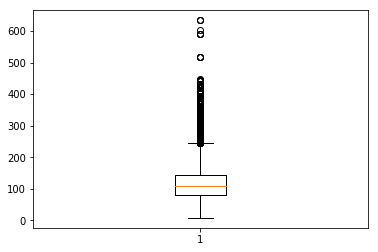

In [24]:
plt.boxplot(houses.busstop1_dist)
# plt.ylim(200,500)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd35cfe0908>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd35cfe0f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd35cfe0518>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd35cfe9668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd35cfe99b0>],
 'means': []}

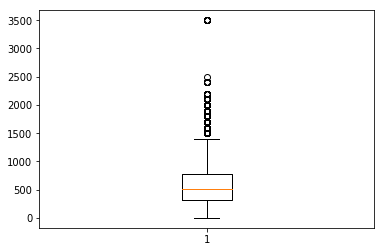

In [25]:
plt.boxplot(houses.nearest_mrt_dist)
# plt.ylim(200,500)

In [26]:
houses[houses.nearest_mrt_dist > 2500]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,flatmodel_apartment,flatmodel_modela2,flatmodel_types1,flatmodel_types2,flatmodel_premiummaisonette,flatmodel_terrace,flatmodel_modelamaisonette,flatmodel_improvedmaisonette,flatmodel_multigeneration,flatmodel_premiumapartmentloft
544,2018-01,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,66,Improved,1981,62,...,0,0,0,0,0,0,0,0,0,0
45055,2014-03,PASIR RIS,3 ROOM,1,CHANGI VILLAGE RD,01 TO 03,67,Improved,1980,34,...,0,0,0,0,0,0,0,0,0,0
45056,2014-03,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,01 TO 03,66,Improved,1981,33,...,0,0,0,0,0,0,0,0,0,0
51974,2014-08,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,01 TO 03,66,Improved,1981,33,...,0,0,0,0,0,0,0,0,0,0
62960,2015-04,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,01 TO 03,66,Improved,1981,65,...,0,0,0,0,0,0,0,0,0,0
69276,2015-08,PASIR RIS,3 ROOM,1,CHANGI VILLAGE RD,01 TO 03,66,Improved,1980,64,...,0,0,0,0,0,0,0,0,0,0
88312,2016-08,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,66,Improved,1981,63,...,0,0,0,0,0,0,0,0,0,0
104348,2017-06,PUNGGOL,4 ROOM,614A,EDGEFIELD PLAINS,01 TO 03,92,Model A,2012,94,...,0,0,0,0,0,0,0,0,0,0
104349,2017-06,PUNGGOL,4 ROOM,602C,PUNGGOL CTRL,13 TO 15,94,Model A,2012,94,...,0,0,0,0,0,0,0,0,0,0
104350,2017-06,PUNGGOL,4 ROOM,165A,PUNGGOL CTRL,16 TO 18,95,Premium Apartment,2004,85,...,0,0,0,0,0,0,0,0,0,0
